# Data preparation and feature engineering

In [43]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit


# ==========================================
# CONFIGURATION
# ==========================================
TIME_WINDOW = "15min"
FILE_PATH   = "./derivative_data_2025.parquet"
N_TRIALS    = 20 # Optimization trials
RANDOM_SEED = 42
VAL_FRAC    = 0.10  # 10% of training set used for validation


# ==========================================
# DATA LOADING & PARSING
# ==========================================
print(">>> Loading and Parsing Data...")
df = pd.read_parquet(FILE_PATH, engine="pyarrow")

if pd.api.types.is_numeric_dtype(df["timestamp"]):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"])


df = df[df["instrument_name"].str.contains("BTC")] # Filter for BTC options

# Format is "Asset-Expiry-Strike-Type" (e.g., BTC-27DEC25-90000-P)
# We parse this to reconstruct the Volatility Surface.
split_names = df["instrument_name"].str.split("-", expand=True)
df["Expiry_Str"] = split_names[1]
df["Strike"] = split_names[2].astype(float)
df["Type"] = split_names[3]

# Convert Expiry to datetime to calculate "Time to Maturity"
df["Expiry"] = pd.to_datetime(df["Expiry_Str"], format="%d%b%y", errors="coerce")
df["days_to_expiry"] = (df["Expiry"] - df["timestamp"]).dt.total_seconds() / (24 * 3600)

# Calculate Moneyness (Spot / Strike). 1.0 = At The Money (ATM).
df["moneyness"] = df["index_price"] / df["Strike"]

# Filter out bad data
df["iv"] = pd.to_numeric(df["iv"], errors="coerce") # Ensure IV is numeric
df = df[df["iv"] > 0]


# ==========================================
# FEATURE ENGINEERING
# ==========================================
print(f">>> Resampling to {TIME_WINDOW} bars...")

def calculate_features(sub_df):
    # sub_df contains all trades that happened in one 15-min window
    if sub_df.empty:
        return None
    stats = {}

    # --- IV SURFACE FEATURES ---

    # 1. ATM IV
    # We only look at options +/- 2% from spot price to avoid "Smile" bias.
    atm_mask = sub_df["moneyness"].between(0.98, 1.02)
    stats["ATM_IV"] = sub_df.loc[atm_mask, "iv"].mean() if atm_mask.any() else sub_df["iv"].mean()

    # 2. Skew
    # Average Put IV minus Average Call IV. Positive Skew = Market fears a crash.
    put_iv = sub_df.loc[sub_df["Type"] == "P", "iv"].mean()
    call_iv = sub_df.loc[sub_df["Type"] == "C", "iv"].mean()
    stats["Skew"] = (put_iv if pd.notna(put_iv) else stats["ATM_IV"]) - \
                    (call_iv if pd.notna(call_iv) else stats["ATM_IV"])

    # 3. Term Structure (The Time Horizon)
    # Ratio of Far-dated IV (>10 days) to Near-dated IV (<=10 days).
    near_mask = sub_df["days_to_expiry"] <= 10
    far_mask = sub_df["days_to_expiry"] > 10
    iv_near = sub_df.loc[near_mask, "iv"].mean()
    iv_far = sub_df.loc[far_mask,  "iv"].mean()
    # Safety checks for division by zero or missing maturities
    if pd.isna(iv_near) or iv_near == 0: iv_near = stats["ATM_IV"]
    if pd.isna(iv_far): iv_far = stats["ATM_IV"] # 
    stats["Term_Structure"] = iv_far / iv_near

    # MARKET DATA
    # We take the LAST price of the bucket (Close) and SUM of volume
    stats["Close_Price"] = sub_df["index_price"].iloc[-1]
    stats["Volume"] = sub_df["amount"].sum()

    return pd.Series(stats)

# Aggregation: Convert Tick Data -> Time Series Data
df_grouped = df.set_index("timestamp").resample(TIME_WINDOW).apply(calculate_features)
df_grouped = df_grouped.ffill() # Fill gaps (if no trades in 15 mins, carry forward)


# ==========================================
# TARGET CREATION (DELTA)
# ==========================================
print(">>> Creating Features & Targets...")

# Feature 1: Momentum (Recent changes in IV)
df_grouped["ATM_IV_Change"] = df_grouped["ATM_IV"].diff()
df_grouped["ATM_IV_Change_Lag1"] = df_grouped["ATM_IV_Change"].shift(1)

# Feature 2: Realized Volatility (Past 1 hour)
df_grouped["returns"] = np.log(df_grouped["Close_Price"] / df_grouped["Close_Price"].shift(1))
# We shift(1) BEFORE rolling to ensure we only use PAST returns.
# This prevents "Look-Ahead Bias" where we might accidentally include the current candle's volatility.
df_grouped["Realized_Vol"] = df_grouped["returns"].shift(1).rolling(window=4).std()

# *** TARGET ***
# We predict the CHANGE in IV for the NEXT period (t+1)
df_grouped["Target_Delta"] = df_grouped["ATM_IV"].shift(-1) - df_grouped["ATM_IV"]

model_data = df_grouped.dropna()

feature_cols = ["ATM_IV", "Skew", "Term_Structure", "Realized_Vol",
                "Volume", "ATM_IV_Change", "ATM_IV_Change_Lag1"]

X = model_data[feature_cols]
y = model_data["Target_Delta"]


# ==========================================
# SPLIT DATA (TRAIN/VAL/TEST)
# ==========================================
# We use a 3-way split to prevent data leakage.
## 1. Train (Weights) -> 2. Val (Hyperparams/Stopping) -> 3. Test (Final Eval)

# Hold out Test Set (Final 20%)
split_idx = int(len(model_data) * 0.8)

X_train_full = X.iloc[:split_idx]
y_train_full = y.iloc[:split_idx]
X_test       = X.iloc[split_idx:]
y_test       = y.iloc[split_idx:]

# Create Validation Set from the end of Training (Last 10%)
val_size  = max(1, int(len(X_train_full) * VAL_FRAC)) # Ensure at least 1 row
val_start = len(X_train_full) - val_size

X_train = X_train_full.iloc[:val_start]
y_train = y_train_full.iloc[:val_start]
X_val   = X_train_full.iloc[val_start:]
y_val   = y_train_full.iloc[val_start:]

print(f"Data Prepared.")
print(f"Train Rows: {len(X_train)} | Val Rows: {len(X_val)} | Test Rows: {len(X_test)}")

>>> Loading and Parsing Data...
>>> Resampling to 15min bars...
>>> Creating Features & Targets...
Data Prepared.
Train Rows: 23432 | Val Rows: 2603 | Test Rows: 6509


# LightGBM

>>> Tuning LightGBM...
Best LGBM Params: {'learning_rate': 0.06404700832256044, 'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 10, 'reg_alpha': 3.55634953249854e-05, 'reg_lambda': 6.367505626638462, 'colsample_bytree': 0.9989561373468004}
>>> Training Final LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	train's l2: 17.987	valid's l2: 15.8606
LightGBM RMSE: 3.953498


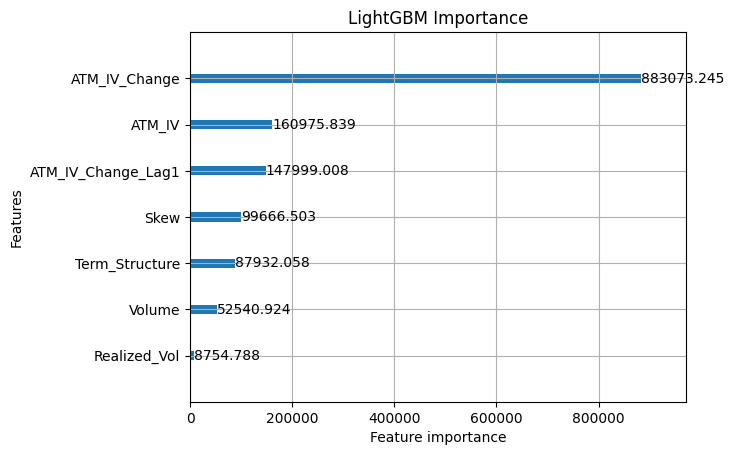

In [44]:
print(">>> Tuning LightGBM...")

def objective_lgbm(trial):
    # We define a "Search Space" for Optuna.
    # Unlike Grid Search which checks fixed points, Optuna samples from these distributions.
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1, # Suppress LightGBM output
        "boosting_type": "gbdt", # Gradient Boosted Decision Trees
        "random_state": RANDOM_SEED,

        # Structure Params: Control complexity
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),

        # Regularization Params: Prevent Overfitting

        # We use log=True because the difference between 0.001 and 0.01 is huge (10x),
        # but the difference between 5.0 and 5.1 is negligible.
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

        # Randomness: Subsample features to make trees more robust
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    # Inner Validation Loop (Walk-Forward).
    # We split X_train_full into 3 chronological chunks to test stability.
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        x_tr, x_va = X_train_full.iloc[tr_idx], X_train_full.iloc[va_idx]
        y_tr, y_va = y_train_full.iloc[tr_idx], y_train_full.iloc[va_idx]

        model = lgb.LGBMRegressor(**params, n_estimators=500)
        # Train on the fold's history, validate on the fold's future
        model.fit(
            x_tr, y_tr,
            eval_set=[(x_va, y_va)],
            callbacks=[lgb.early_stopping(stopping_rounds=20, verbose=False)]
        )
        preds = model.predict(x_va)
        scores.append(np.sqrt(mean_squared_error(y_va, preds)))

    return float(np.mean(scores))

# Run the optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS)

print(f"Best LGBM Params: {study_lgbm.best_params}")

# ==========================================
# FINAL TRAINING
# ==========================================
print(">>> Training Final LightGBM...")

# Initialize model with the WINNING hyperparameters found above
lgbm_final = lgb.LGBMRegressor(**study_lgbm.best_params, n_estimators=1000, random_state=RANDOM_SEED)

# We train on the Training Set and stop based on the Validation Set.
lgbm_final.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)], # We add (X_train, y_train) to eval_set so we can plot the learning curve later
    eval_names=['train', 'valid'],  # Naming ensures we can query results for charts
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Evaluate on the Test Set
lgbm_pred = lgbm_final.predict(X_test)
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))

print(f"LightGBM RMSE: {lgbm_rmse:.6f}")
lgb.plot_importance(lgbm_final, importance_type="gain", title="LightGBM Importance")
plt.show()

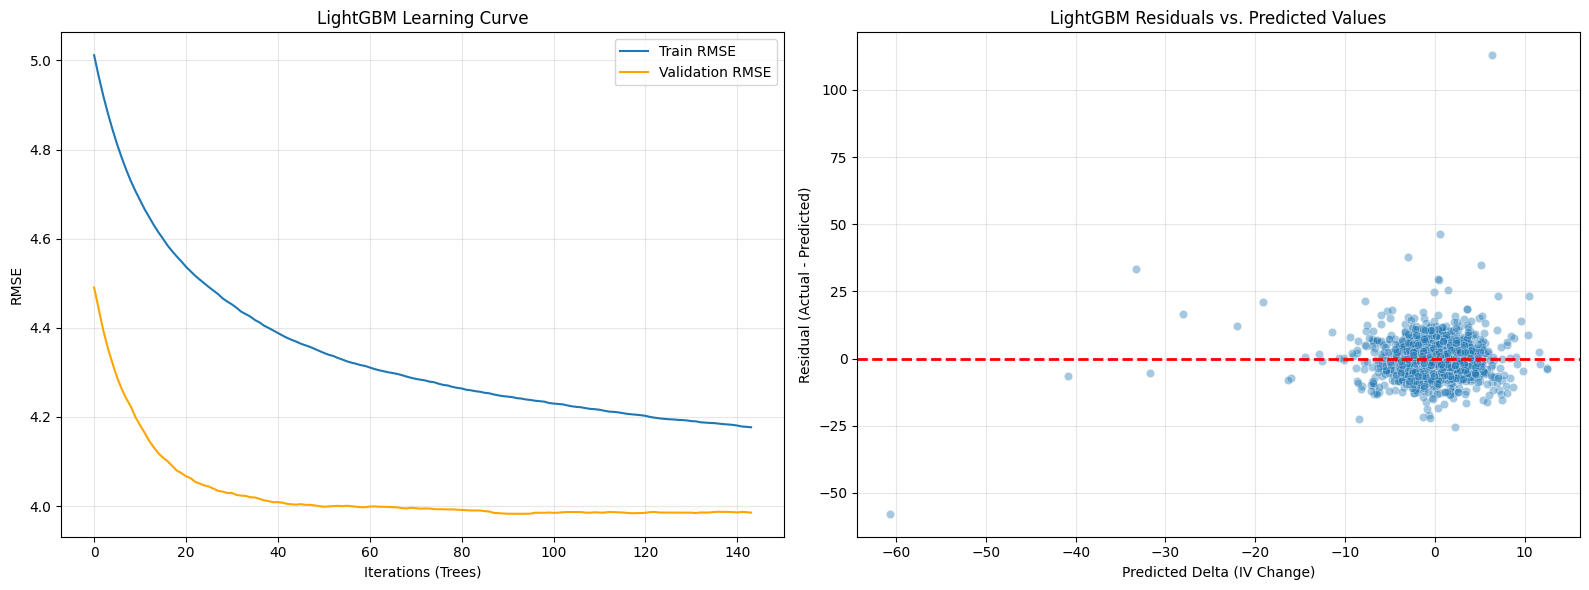

In [45]:
# ==========================================
# DIAGNOSTICS: LIGHTGBM
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# We retrieve the internal history of the model. 
# LightGBM recorded the error of every single tree during training.
results = lgbm_final.evals_result_

# FIX: Dynamic key detection (handles 'l2', 'rmse', etc.)
# LightGBM keys are usually 'l2' (MSE) by default if metric isn't specified
metric_key = list(results['train'].keys())[0] 
# print(f"Detected metric: {metric_key}")

train_loss = results['train'][metric_key]
valid_loss = results['valid'][metric_key]

# Convert MSE (l2) to RMSE for easier interpretation
if metric_key == 'l2':
    train_loss = np.sqrt(train_loss)
    valid_loss = np.sqrt(valid_loss)
    y_label = 'RMSE'
else:
    y_label = metric_key.upper()

epochs = len(train_loss)
x_axis = range(0, epochs)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- CHART 1: LEARNING CURVE ---
axes[0].plot(x_axis, train_loss, label='Train RMSE')
axes[0].plot(x_axis, valid_loss, label='Validation RMSE', color='orange')
axes[0].set_title('LightGBM Learning Curve')
axes[0].set_ylabel(y_label)
axes[0].set_xlabel('Iterations (Trees)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- CHART 2: RESIDUALS VS PREDICTIONS (Homoscedasticity Check) ---
# Residual = Actual Value - Predicted Value
residuals = y_test - lgbm_pred

sns.scatterplot(x=lgbm_pred, y=residuals, alpha=0.4, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', lw=2) # Zero line
axes[1].set_title('LightGBM Residuals vs. Predicted Values')
axes[1].set_xlabel('Predicted Delta (IV Change)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# CatBoost

>>> Tuning CatBoost...
Best CatBoost Params: {'depth': 4, 'learning_rate': 0.07212679866440569, 'l2_leaf_reg': 0.28704507900135323, 'subsample': 0.8153710515701748, 'min_data_in_leaf': 49}
>>> Training Final CatBoost...
0:	learn: 4.9975905	test: 4.4807772	best: 4.4807772 (0)	total: 2.67ms	remaining: 4s
100:	learn: 4.1170761	test: 3.9834147	best: 3.9751436 (88)	total: 233ms	remaining: 3.23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.975143568
bestIteration = 88

Shrink model to first 89 iterations.
CatBoost RMSE: 3.946894


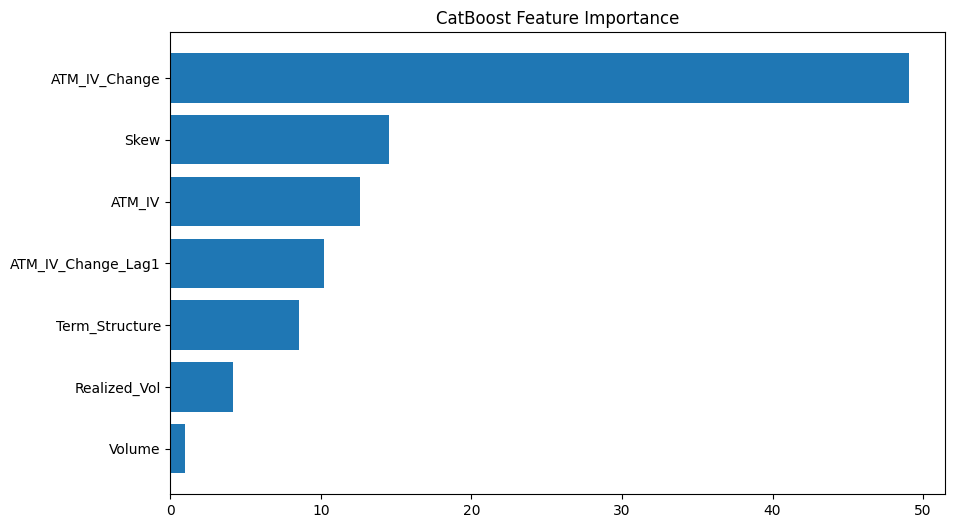

In [46]:
print(">>> Tuning CatBoost...")

def objective_cat(trial):
    # CatBoost Hyperparameters
    params = {
        "loss_function": "RMSE",
        "verbose": False,
        "random_seed": RANDOM_SEED,
        "iterations": 1000,
        
        # Structure: CatBoost uses Symmetric Trees. 
        # 'Depth' is a hard constraint. Unlike LightGBM, the tree is balanced.
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),

        # L2 regularization on leaf weights
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),

        # Stochasticity: Randomly sample data for each tree to improve generalization
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),

        # Minimum samples in a leaf
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
    }

    # The exact same Validation Strategy (TimeSeriesSplit) as LightGBM
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for tr_idx, va_idx in tscv.split(X_train_full):
        x_tr, x_va = X_train_full.iloc[tr_idx], X_train_full.iloc[va_idx]
        y_tr, y_va = y_train_full.iloc[tr_idx], y_train_full.iloc[va_idx]

        model = CatBoostRegressor(**params)
        model.fit(
            x_tr, y_tr,
            eval_set=(x_va, y_va), 
            early_stopping_rounds=20,
            verbose=False
        )
        scores.append(np.sqrt(mean_squared_error(y_va, model.predict(x_va))))

    return float(np.mean(scores))

# Run Optimization
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=N_TRIALS)

print(f"Best CatBoost Params: {study_cat.best_params}")

# ==========================================
# FINAL TRAINING
# ==========================================
print(">>> Training Final CatBoost...")

# Initialize model with the WINNING hyperparameters found above
cat_params = dict(study_cat.best_params)
cat_params.update({"iterations": 1500, "loss_function": "RMSE", "random_seed": RANDOM_SEED, "verbose": False})

cat_final = CatBoostRegressor(**cat_params)

# Train on Train, Stop on Val
cat_final.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=100
)

# Evaluate on the Test Set
cat_pred = cat_final.predict(X_test)
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_pred))

print(f"CatBoost RMSE: {cat_rmse:.6f}")

# Feature Importance Plot
# CatBoost calculates importance differently than LightGBM.
feat_imp = cat_final.get_feature_importance()
sorted_idx = np.argsort(feat_imp)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feat_imp[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_cols)[sorted_idx])
plt.title("CatBoost Feature Importance")
plt.show()

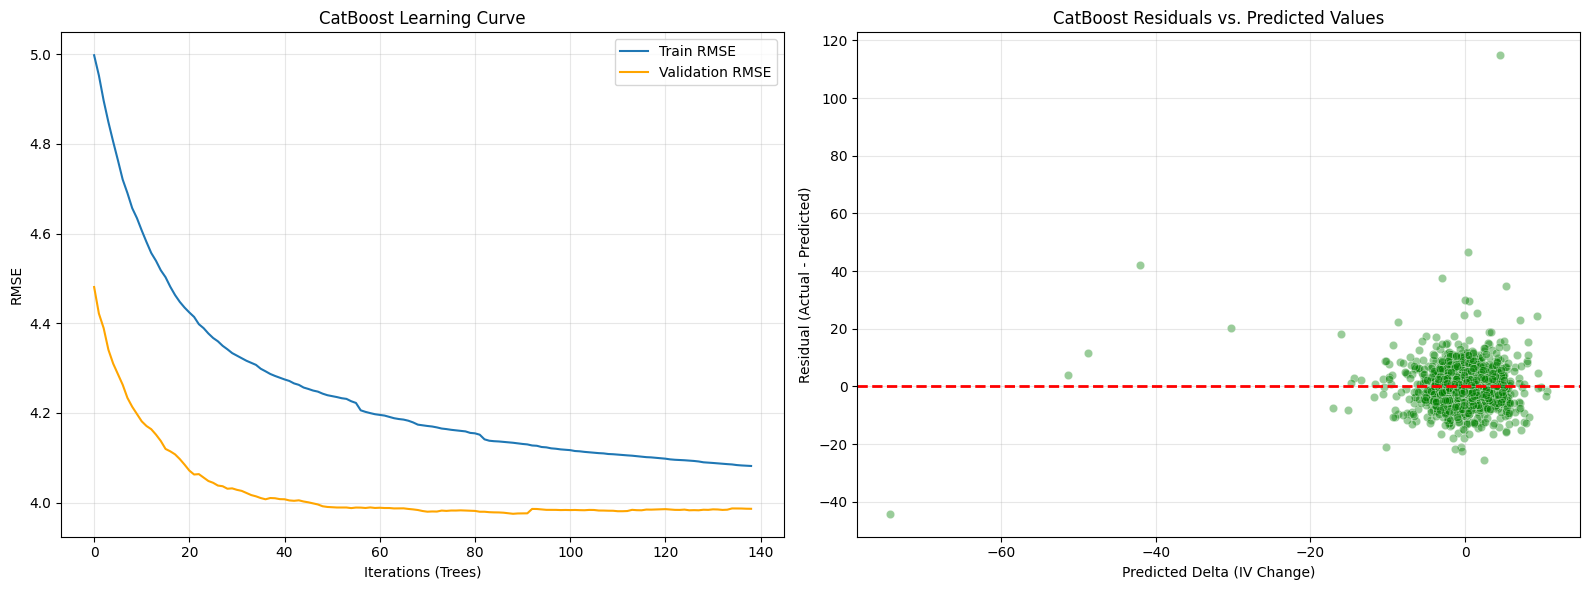

In [47]:
# ==========================================
# DIAGNOSTICS: CATBOOST
# ==========================================

# Retrieve training history
results = cat_final.get_evals_result()
train_history = results['learn']['RMSE']
val_history = results['validation']['RMSE']
x_axis = range(0, len(train_history))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- CHART 1: LEARNING CURVE ---
axes[0].plot(x_axis, train_history, label='Train RMSE')
axes[0].plot(x_axis, val_history, label='Validation RMSE', color='orange')
axes[0].set_title('CatBoost Learning Curve')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('Iterations (Trees)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# --- CHART 2: RESIDUALS VS PREDICTIONS ---
residuals_cat = y_test - cat_pred

# Scatter Plot
sns.scatterplot(x=cat_pred, y=residuals_cat, alpha=0.4, color='green', ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_title('CatBoost Residuals vs. Predicted Values')
axes[1].set_xlabel('Predicted Delta (IV Change)')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary

Baseline RMSE: 4.560410
LightGBM RMSE: 3.953498 (Improvement: 13.31%)
CatBoost RMSE: 3.946894 (Improvement: 13.45%)
LightGBM Directional Acc: 61.77%
CatBoost Directional Acc: 62.14%


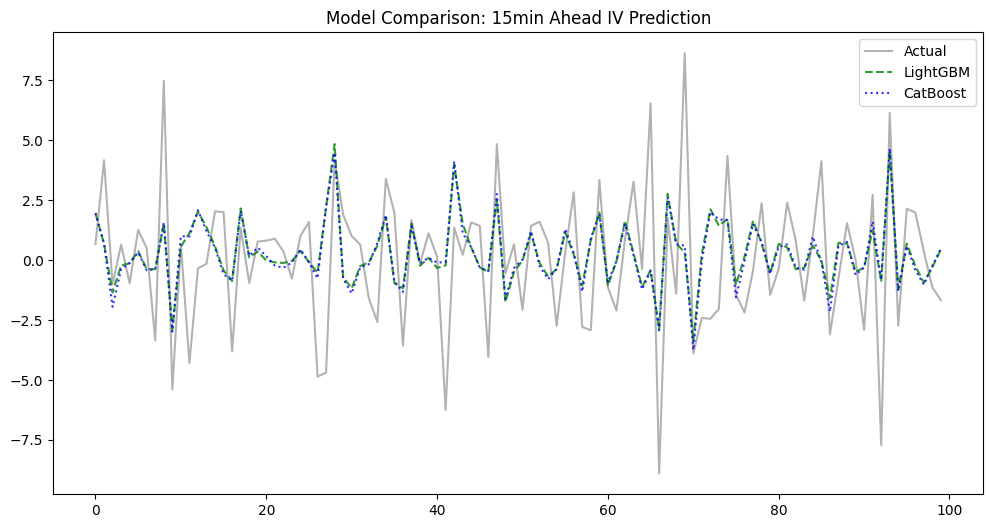

In [48]:
# ==========================================
# 6. MODEL EVALUATION & COMPARISON
# ==========================================

# The Naive Baseline (The "Random Walk" Hypothesis)
# In efficient markets, the best predictor of Price(t+1) is Price(t).
# Since our target is "Change" (Delta), the Naive prediction is always 0.
naive_rmse = np.sqrt(mean_squared_error(y_test, np.zeros_like(y_test)))

# RMSE Comparison
print(f"Baseline RMSE: {naive_rmse:.6f}")
print(f"LightGBM RMSE: {lgbm_rmse:.6f} (Improvement: {((naive_rmse - lgbm_rmse)/naive_rmse)*100:.2f}%)")
print(f"CatBoost RMSE: {cat_rmse:.6f} (Improvement: {((naive_rmse - cat_rmse)/naive_rmse)*100:.2f}%)")

# Directional Accuracy
# RMSE measures magnitude, but in trading, SIGN (Long vs Short) matters most.
# We convert predictions to +1 (Up) or -1 (Down).
# We filter out instances where y_test is exactly 0 to avoid dividing by zero or ambiguity.
lgbm_acc = accuracy_score(np.sign(y_test[y_test!=0]), np.sign(lgbm_pred[y_test!=0]))
cat_acc  = accuracy_score(np.sign(y_test[y_test!=0]), np.sign(cat_pred[y_test!=0]))

print(f"LightGBM Directional Acc: {lgbm_acc*100:.2f}%")
print(f"CatBoost Directional Acc: {cat_acc*100:.2f}%")

# Final Plot
# Only the first 100 points of the Test Set for readability.
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:100], label="Actual", color="black", alpha=0.3)
plt.plot(lgbm_pred[:100], label="LightGBM", color="green", linestyle="--", alpha=0.8)
plt.plot(cat_pred[:100], label="CatBoost", color="blue", linestyle=":", alpha=0.8)
plt.title("Model Comparison: 15min Ahead IV Prediction")
plt.legend()
plt.show()

Why validation curve is below training curve?

In [49]:
# Standard Deviation tells us how much the target (IV Change) wiggles
train_volatility = y_train.std()
val_volatility = y_val.std()

print(f"Training Set Std Dev (Noise Level): {train_volatility:.4f}")
print(f"Validation Set Std Dev (Noise Level): {val_volatility:.4f}\n")

if val_volatility < train_volatility:
    print("CONCLUSION: The Validation period was 'quieter' than the Training period.")
    print("It is natural for RMSE to be lower when there is less movement to predict.")
else:
    print("CONCLUSION: The model is actually underfitting the training data (High Bias).")

Training Set Std Dev (Noise Level): 5.0645
Validation Set Std Dev (Noise Level): 4.5406

CONCLUSION: The Validation period was 'quieter' than the Training period.
It is natural for RMSE to be lower when there is less movement to predict.
